In [1]:
import pandas as pd
import numpy as np
from dotenv import dotenv_values
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
import squarify #treemapy (squarified)

import math

millnames = ['',' \gls{k}',' \gls{m}',' \gls{bn}']

def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
    return '{:.3g}{}'.format(n / 10**(3 * millidx), millnames[millidx])

config = dotenv_values("./../../config/.env") # take environment variables from .env.
base_path = Path(config["BASE_PATH"])
data_path = base_path/"data"
path_10k = data_path/"raw"/"10k"
path_stoxx = data_path/"raw"/"stoxx"
writing_path = base_path/"writing"/"MSc-Thesis-Emerging-Risks"
table_path = writing_path/"tables"
figure_path = writing_path/"figures"/"plots"

mm = 25.4
textwidth = 149/mm

# plt.rcParams.keys()
aspect =  1.618
width = textwidth*0.9
height = width / aspect
matplotlib.rcParams.update({
    "font.family": 'sans',  # use serif/main font for text elements
    "font.size": 7,
    "text.usetex": False,   # use inline math for ticks
    "pgf.rcfonts": False,   # don't setup fonts from rc parameters
    "pgf.texsystem" : "lualatex",
    "figure.figsize": [width, height]})
cmap = matplotlib.cm.tab10
colors = [cmap(i) for i in range(cmap.N)]
from textwrap import wrap

with open(base_path/"config"/"sic-code-map.json", "r") as f:
    sic_code_map = json.load(f)

# Prepare and Filter Data

In [2]:
df_10k_master = pd.read_pickle(path_10k/"master_10k.pkl")
df_stoxx_master = pd.read_pickle(path_stoxx/"master_stoxx.pkl")
df_10k = pd.read_pickle(path_10k/"paragraphs_10k.pkl")
df_stoxx = pd.read_pickle(path_stoxx/"paragraphs_stoxx.pkl")
# Do not include the Swiss Re reports prior to 1999 in the descriptive statistics
df_stoxx_master = df_stoxx_master[pd.to_numeric(df_stoxx_master.year) >= 1999]
df_stoxx = df_stoxx[df_stoxx.report_id.isin(df_stoxx_master.report_id.unique())]
#These two reports could not be extracted as they are scans!
id_s = df_stoxx[df_stoxx.report_id.apply(lambda x: x[:11] != "SwissReFull")].report_id.unique()
missing_reports = [x for x in df_stoxx_master.reset_index().report_id.unique() if x not in  id_s]
print("Missing Reports", missing_reports)
df_stoxx_master = df_stoxx_master[~df_stoxx_master.report_id.isin(missing_reports)]
df_stoxx = df_stoxx[~df_stoxx.report_id.isin(missing_reports)]
df_stoxx["unexpected_loss_kw"] = False
df_stoxx.loc[(df_stoxx.unexpected_kw & df_stoxx.loss_kw), "unexpected_loss_kw"] = True
df_stoxx["filing_type"] = "PDF"
df_10k["unexpected_loss_kw"] = False
df_10k.loc[(df_10k.unexpected_kw & df_10k.loss_kw), "unexpected_loss_kw"] = True
df_10k["filing_type"] = "10-K"

print("Raw",  millify(df_10k.shape[0] + df_stoxx.shape[0]))
df_total = pd.concat([df_stoxx.drop(columns=["page_no"]), df_10k[df_10k.item.isin(["2", "6", "7", "8"])].drop(columns=["item"])])
print("Relavant 10-k Items", millify(df_total.shape[0]))
df_total = df_total.drop_duplicates(subset=["text"])
print("Remove Duplicates", millify(df_total.shape[0]))
df_total = df_total[df_total.n_words >10]
print("Remove n > 10", millify(df_total.shape[0]))
df_total.sort_values(by=["n_words"], ascending=True).drop(columns=["loss_kw","unexpected_kw", "unexpected_loss_kw"]).to_pickle(data_path/"preprocessed"/"paragraphs_clean.pkl")

Missing Reports ['AegonNV-AR_2003', 'HelvetiaHoldingAG-AR_2002']
Raw 9.59 \gls{m}
Relavant 10-k Items 5.65 \gls{m}
Remove Duplicates 2.8 \gls{m}
Remove n > 10 2.02 \gls{m}


In [3]:
df_stats = df_total.groupby(
        "report_id", 
        as_index=False
    ).agg(
        {
            "paragraph_nr": "count", 
            "n_words": "sum", 
            "loss_kw": "sum", 
            "unexpected_kw": "sum",
            "unexpected_loss_kw": "sum"
        }
    ).rename(
        columns={"paragraph_nr": "n_paragraphs"}
    )
df_stats.report_id = df_stats.report_id.astype(str)
df_stats = df_stats.set_index("report_id")

df_stoxx_master["filing_type"] = "PDF"
df_10k_master["filing_type"] = "10-K"

df_master = pd.concat([
        df_stoxx_master[~df_stoxx_master.report_id.isin(missing_reports)].rename(columns={"only_insurance": "segment"}),
        df_10k_master.rename(columns={"sic": "segment"})[["report_id", "company", "year", "filing_type", "segment"]]
    ])
df_master.report_id = df_master.report_id.astype(str)
df_master = df_master.set_index("report_id")

df_stats = df_stats.join(
    df_master,
    how="left", 
    lsuffix="_master", 
    rsuffix="_para"
)

df_stats.year = pd.to_numeric(df_stats.year)
df_stats.filing_type = df_stats.filing_type.astype(str)
df_stats.segment = df_stats.segment.apply(lambda x: "insurance" if x == True else ( x if str(x)[0]=="6" else "partly-insurance"))
df_stats.segment = df_stats.segment.apply(lambda x: f"STOXX {x}" if x in ["insurance", "partly-insurance"] else f"10K {sic_code_map[x]}")

In [4]:
column_name_mapping ={
        "report_id": "\\# Reports", 
        "n_words": "\\# Words", 
        "n_paragraphs": "\\# Paragraphs",
        "loss_kw": "\\# loss",
        "unexpected_kw": "\\# unexpected",
        "unexpected_loss_kw": "\\# unexpected \\amp loss",
        "words_per_para": "Avg. \\# Words / paragraph",
        "paragraphs_per_report": "\\# Paragraphs / report",
        "loss_kw": "\% Para. cont. *loss*",
        "unexpected_kw": "\% Para. cont. *unexpected*",
        "unexpected_loss_kw": "\% Para. cont. *unexpected* \\amp *loss*"
         }

In [6]:
df_risks = pd.read_pickle(base_path/'data/processed/df_risk_descriptions.pkl')
df_risks = df_risks[df_risks.Source != "Sonar - internal"].drop(columns=["emb_bge_large_en"])

df_risks["n_words"] = df_risks.Description.str.split(" ").apply(len)
df_risks["n_paragraphs"] = df_risks.Description.str.split().apply(len)
df_risks["loss_kw"] = df_risks.Description.str.findall("loss").apply(lambda x: len(x) >0)
df_risks["unexpected_kw"] = df_risks.Description.str.findall("unexpected").apply(lambda x: len(x) >0)
df_risks["unexpected_loss_kw"] = False
df_risks.loc[(df_risks.unexpected_kw & df_risks.loss_kw), "unexpected_loss_kw"] = True
df_risks["Document type"] = "Risk Report"
df_risks["n_paragraphs"] = 1
df_risks = df_risks.reset_index(drop=True).reset_index().rename(columns={"index": "report_id"})

In [7]:
stats_filing_year = pd.concat([
        df_stats.reset_index().rename(columns={
        "filing_type": "Document type",
        "year": "Year",
    }), 
        df_risks
    ]).groupby(["Document type", "Year"]).agg(
        {
            "report_id": "count", 
            "n_paragraphs": "sum", 
            "n_words": "sum", 
            "loss_kw": "sum", 
            "unexpected_kw": "sum", 
            "unexpected_loss_kw": "sum"
        })
stats_filing_year.loss_kw = stats_filing_year.loss_kw/stats_filing_year.n_paragraphs*100
stats_filing_year.unexpected_kw = stats_filing_year.unexpected_kw/stats_filing_year.n_paragraphs*100
stats_filing_year.unexpected_loss_kw = stats_filing_year.unexpected_loss_kw/stats_filing_year.n_paragraphs*100
stats_filing_year["words_per_para"] = stats_filing_year.n_words/stats_filing_year.n_paragraphs
stats_filing_year["paragraphs_per_report"] = stats_filing_year.n_paragraphs/stats_filing_year.report_id
stats_filing_year = stats_filing_year.rename(
    columns=column_name_mapping)

In [8]:
df_plot = stats_filing_year.reset_index()
df_plot= df_plot[df_plot["Document type"] != "Risk Report"]
df_plot = df_plot.rename(columns=column_name_mapping).melt(
    id_vars=['Document type', "Year"],
    value_vars=["\\# Reports",
                "\\# Words",
                "\% Para. cont. *loss*",
                "\% Para. cont. *unexpected*", 
                "\% Para. cont. *unexpected* \\amp *loss*", 
                "Avg. \\# Words / paragraph", 
                "\\# Paragraphs / report",
                "\\# Paragraphs"])


# Tables

In [9]:
pd.concat([
        df_stats.rename(columns={"filing_type": "Document type"}).reset_index().rename(columns={"index": "report_id"}), 
        df_risks]
    ).groupby("Document type").agg({
    "report_id": "count", 
    "n_words": "sum", 
    "n_paragraphs": "sum", 
    "loss_kw": "sum", 
    "unexpected_kw": "sum", 
    "unexpected_loss_kw": "sum"})\
    .rename(columns=column_name_mapping).style.format(
        precision=2,
        formatter=millify).to_latex(
            table_path/"stats_overview_2.tex",
            position="H",
            caption="Descriptive statistics of all data.",
            label="tab:stats_overview",
            environment="longtable",
            column_format="P{1.7cm}|P{1.7cm}P{1.3cm}P{1.2cm}P{1cm}P{2.3cm}P{2.3cm}",
            sparse_index=False,
            sparse_columns=False,
            hrules=True)

In [10]:
stats_filing_year[["\\# Reports", "\\# Words","\\# Paragraphs", "Avg. \\# Words / paragraph","\\# Paragraphs / report"]].style.format(
                precision=2,
                formatter=millify
            ).to_latex(
                table_path/"stats_filing_year_2.tex",
                position="H",
                caption="Descriptive statistics of the dataset by document type and year.",
                label="tab:stats_filing_year",
                environment="longtable",
                column_format="P{1.5cm}l|P{1.5cm}P{1.8cm}P{2cm}P{2.3cm}P{2.3cm}",
                sparse_index=False,
                sparse_columns=False,
                hrules=True,
                )

In [11]:
columns = ["\\# Paragraphs", "\% Para. cont. *loss*", "\% Para. cont. *unexpected*", "\% Para. cont. *unexpected* \\amp *loss*"]
stats_filing_year.loc[["10-K", "PDF"]][columns].style.format(
                formatter=millify
            ).to_latex(
                table_path/"stats_filing_year_shares_2.tex",
                position="H",
                caption="Descriptive statistics (shares) of the dataset by filing type and year",
                label="tab:stats_filing_year_shares",
                environment="longtable",
                column_format="P{1.5cm}l|P{2cm}P{1.9cm}P{2.2cm}P{2.2cm}",
                sparse_index=False,
                sparse_columns=False,
                hrules=True,
                )

# Plots

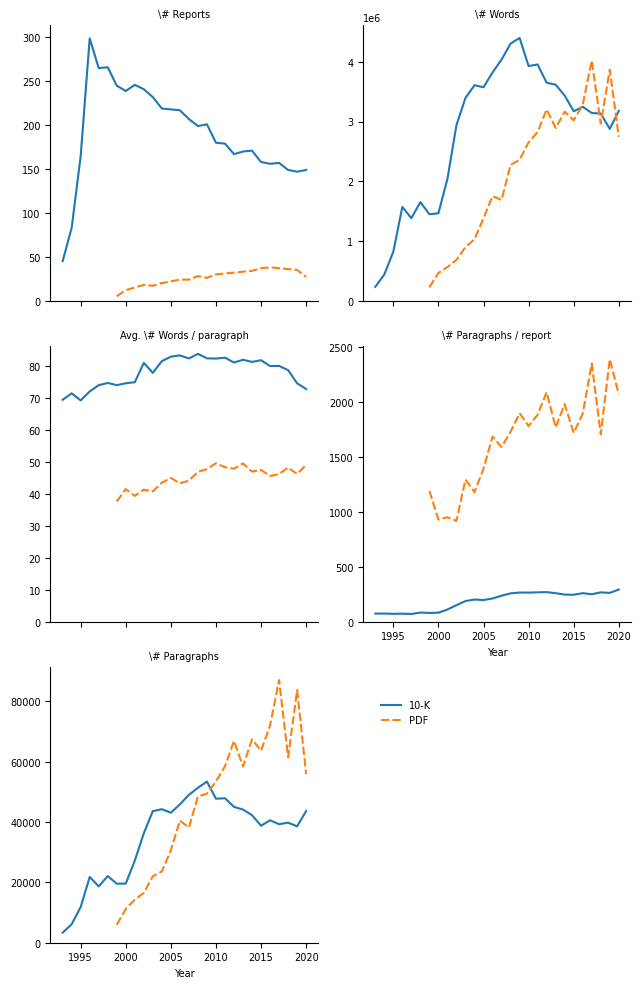

In [12]:
g = sns.FacetGrid(
    data = df_plot[df_plot.variable.isin(
        ["\\# Reports", "\\# Words","Avg. \\# Words / paragraph", "\\# Paragraphs / report", "\\# Paragraphs"])],
    col="variable",
    col_order=["\\# Reports", "\\# Words","Avg. \\# Words / paragraph", "\\# Paragraphs / report", "\\# Paragraphs"],
    sharey=False, 
    margin_titles=False,
    col_wrap=2,
    height=textwidth/(16/9))
g.map_dataframe(sns.lineplot, x="Year", y="value", hue="Document type",style="Document type")
g.set_titles(col_template="{col_name}")
for ax in g.axes:
    bottom, top = ax.get_ylim()
    ax.set_ylim((0, top))
g.set_axis_labels("Year", "")
g.add_legend()
sns.move_legend(g, "upper left", bbox_to_anchor=(0.55, 0.3))
plt.savefig(figure_path/"stats_filing_year_2.pgf", bbox_inches='tight')

/tmp/ipykernel_181898/1320212902.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.variable = dff.variable.apply(lambda x: local_map[x])


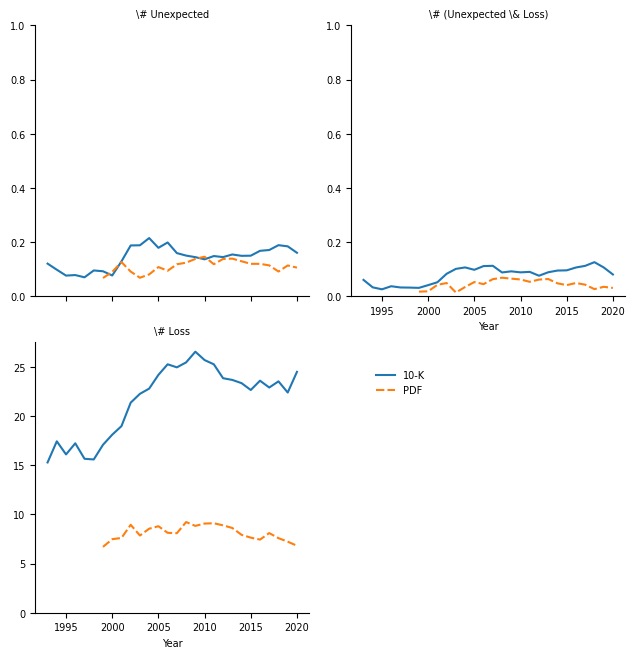

In [13]:
local_map = {
    '\\% Para. cont. *unexpected*': "\\# Unexpected" , 
    '\\% Para. cont. *unexpected* \\amp *loss*': "\\# (Unexpected \\& Loss)",
    '\\% Para. cont. *loss*': "\\# Loss"
}

dff = df_plot[df_plot.variable.isin(list(local_map.keys()))]
dff.variable = dff.variable.apply(lambda x: local_map[x])

g = sns.FacetGrid(
    data = dff,
    col="variable",
    col_order=list(local_map.values()),
    sharey=False, 
    margin_titles=False,
    col_wrap=2,
    height=textwidth/(16/9))
g.map_dataframe(sns.lineplot, x="Year", y="value", hue="Document type",style="Document type")
g.set_titles(col_template="{col_name}")
for (row_val, col_val), ax  in zip(g.axes_dict.items(), g.axes):
    bottom, top = ax.get_ylim()
    if row_val == "\# Loss":
        ax.set_ylim((0, top))
    else:
        ax.set_ylim((0, 1))
g.set_axis_labels("Year", "")
g.add_legend()
sns.move_legend(g, "upper left", bbox_to_anchor=(0.55, 0.45))
plt.savefig(figure_path/"stats_filing_year_shares.pgf", bbox_inches='tight')

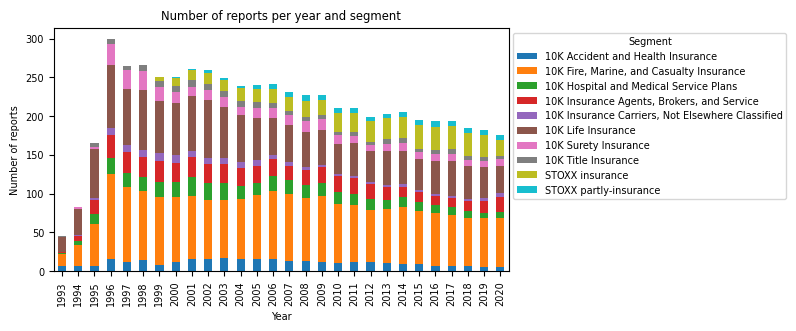

In [18]:
dff = df_stats[["year", "segment"]].value_counts().unstack()
fig, ax = plt.subplots()
dff.plot.bar(
    stacked=True, 
    figsize=(textwidth,textwidth/(13/7)), 
    ax=ax, 
    colormap="tab10")
ax.set_xlabel("Year")
ax.set_ylabel("Number of reports")
ax.set_title("Number of reports per year and segment")
ax.legend(title="Segment", bbox_to_anchor=(1, 1))
plt.savefig(figure_path/"reports_per_year_segment.pgf", bbox_inches="tight")
plt.savefig(figure_path/"reports_per_year_segment.png", bbox_inches="tight")

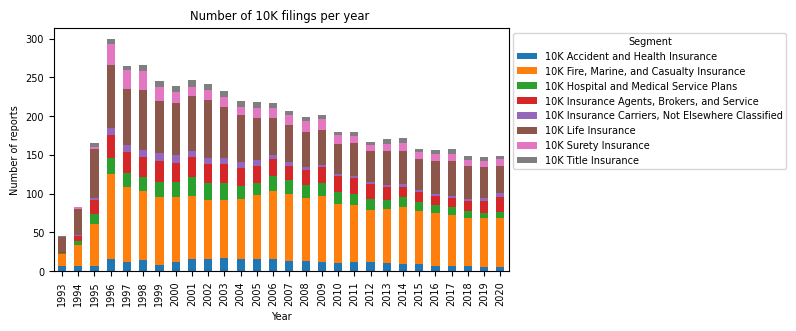

In [19]:
fig, ax = plt.subplots()
dff[[x for x in dff.columns.tolist() if x[:3] == "10K"]].plot.bar(stacked=True, figsize=(textwidth,textwidth/(13/7)), ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Number of reports")
ax.set_title("""Number of 10K filings per year """)
ax.legend(title="Segment", bbox_to_anchor=(1, 1))
plt.savefig(figure_path/"reports_per_year_segment_10k.pgf", bbox_inches="tight")
plt.savefig(figure_path/"reports_per_year_segment_10k.png", bbox_inches="tight")

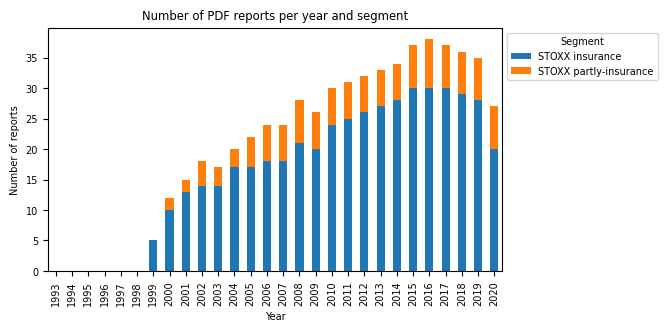

In [20]:
fig, ax = plt.subplots()
dff[[x for x in dff.columns.tolist() if x[:3] != "10K"]].plot.bar(stacked=True, figsize=(textwidth,textwidth/(13/7)), ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Number of reports")
ax.set_title("""Number of PDF reports per year and segment""")
ax.legend(title="Segment", bbox_to_anchor=(1, 1))
plt.savefig(figure_path/"reports_per_year_segment_stoxx.pgf", bbox_inches="tight")
plt.savefig(figure_path/"reports_per_year_segment_stoxx.png", bbox_inches="tight")

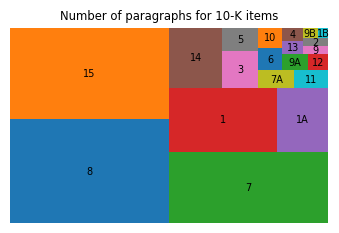

In [21]:
width = textwidth * 0.7
height = width / aspect
matplotlib.rcParams.update({
    "font.family": 'sans',  # use serif/main font for text elements
    "font.size": 7,
    "text.usetex": False,   # use inline math for ticks
    "pgf.rcfonts": False,   # don't setup fonts from rc parameters
    "pgf.texsystem" : "lualatex",
    "figure.figsize": [width, height]})
fig, ax = plt.subplots()
ax = squarify.plot(
    ax=ax, 
    sizes=df_10k.item.value_counts().values, 
    label=df_10k.item.value_counts().index, 
    pad=False, 
    color=colors)
plt.axis('off')
plt.title("Number of paragraphs for 10-K items")
plt.savefig(figure_path/'10-K-items-paragraphcount.pgf', bbox_inches="tight")

width = textwidth
height = width / aspect
matplotlib.rcParams.update({
    "font.family": 'sans',  # use serif/main font for text elements
    "font.size": 7,
    "text.usetex": False,   # use inline math for ticks
    "pgf.rcfonts": False,   # don't setup fonts from rc parameters
    "pgf.texsystem" : "lualatex",
    "figure.figsize": [width, height]})

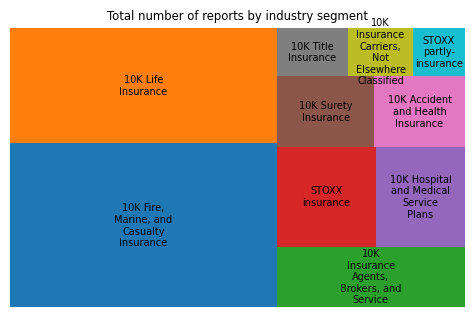

In [22]:
fig, ax = plt.subplots()
ax = squarify.plot(
    ax=ax,
    sizes=df_stats.segment.value_counts().values, 
    label=["\n".join(wrap(x, 12)) for x in df_stats.segment.value_counts().index.tolist()], 
    pad=False,
    color=colors)
plt.axis('off')
plt.title("Total number of reports by industry segment")
plt.savefig(figure_path/'reports_per_segment.pgf')

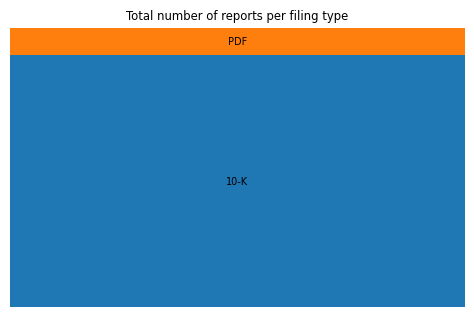

In [23]:
fig, ax = plt.subplots()
ax = squarify.plot(
    ax=ax,
    sizes=df_stats.filing_type.value_counts().values, 
    label=df_stats.filing_type.value_counts().index, 
    pad=False,
    norm_x=10,
    color=colors)
plt.axis('off')
plt.title("Total number of reports per filing type")
plt.savefig(figure_path/'reports_per_filing_type.pgf')

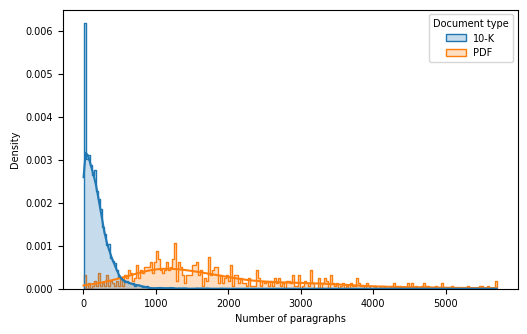

In [24]:
fig, ax = plt.subplots()
g = sns.histplot(
    df_stats.rename(columns={"filing_type": "Document type"}),
    x="n_paragraphs",
    hue="Document type",
    element="step",
    common_norm=False,
    stat="density",
    kde=True,
    ax=ax
)
ax.set_xlabel("Number of paragraphs")
plt.savefig(figure_path/"paragraph_count_hist.pgf", bbox_inches="tight")
plt.savefig(figure_path/"paragraph_count_hist.png", bbox_inches="tight")

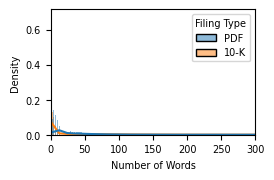

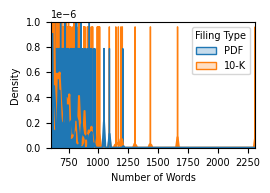

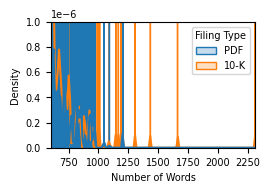

In [115]:
df_stoxx["filing_type"] = "PDF"
df_10k["filing_type"] = "10-K"
df_total = pd.concat([df_stoxx.drop(columns=["page_no"]), df_10k[df_10k.item.isin(["2", "6", "7", "8"])].drop(columns=["item"])])

width = textwidth*0.45
height = width / aspect
matplotlib.rcParams.update({
    "font.family": 'sans',  # use serif/main font for text elements
    "font.size": 7,
    "text.usetex": False,   # use inline math for ticks
    "pgf.rcfonts": False,   # don't setup fonts from rc parameters
    "pgf.texsystem" : "lualatex",
    "figure.figsize": [width, height]})

fig, ax = plt.subplots()
g = sns.histplot(
    df_total.rename(columns={"n_words": "Number of Words", "filing_type": "Filing Type"}),
    x="Number of Words",
    hue="Filing Type",
    common_norm=False,
    stat="density",
    kde=True,
    ax=ax
)
plt.savefig(figure_path/"n_words_raw.pgf", bbox_inches="tight")
plt.savefig(figure_path/"n_words_raw.png", bbox_inches="tight")
ax.set_xlim(0, 300)
plt.savefig(figure_path/"n_words_raw_0_300.pgf", bbox_inches="tight")
plt.savefig(figure_path/"n_words_raw_0_300.png", bbox_inches="tight")

# Remove Duplicates
df_total = df_total.drop_duplicates(subset=["text"])

fig, ax = plt.subplots()
g = sns.histplot(
    df_total.rename(columns={"n_words": "Number of Words", "filing_type": "Filing Type"}),
    x="Number of Words",
    hue="Filing Type",
    element="step",
    common_norm=False,
    stat="density",
    kde=True,
    ax=ax
)
plt.savefig(figure_path/"n_words_duplicates.pgf", bbox_inches="tight")
plt.savefig(figure_path/"n_words_duplicates.png", bbox_inches="tight")
ax.set_xlim(0, 300)
plt.savefig(figure_path/"n_words_duplicates_0_300.pgf", bbox_inches="tight")
plt.savefig(figure_path/"n_words_duplicates_0_300.png", bbox_inches="tight")
ax.set_xlim(300, 600)
ax.set_ylim(0, 0.00025)
plt.savefig(figure_path/"n_words_duplicates_300_600.pgf", bbox_inches="tight")
plt.savefig(figure_path/"n_words_duplicates_300_600.png", bbox_inches="tight")
ax.set_xlim(600, df_total.n_words.max())
ax.set_ylim(0, 0.000001)
plt.savefig(figure_path/"n_words_duplicates_600_.pgf", bbox_inches="tight")
plt.savefig(figure_path/"n_words_duplicates_600_.png", bbox_inches="tight")


# Remove paragraphs with less than 10 words
df_total = df_total[df_total.n_words >10]
fig, ax = plt.subplots()
g = sns.histplot(
    df_total.rename(columns={"n_words": "Number of Words", "filing_type": "Filing Type"}),
    x="Number of Words",
    hue="Filing Type",
    element="step",
    common_norm=False,
    stat="density",
    kde=True,
    ax=ax
)
plt.savefig(figure_path/"n_words_clean.pgf", bbox_inches="tight")
plt.savefig(figure_path/"n_words_clean.png", bbox_inches="tight")
ax.set_xlim(0, 300)
plt.savefig(figure_path/"n_words_clean_0_300.pgf", bbox_inches="tight")
plt.savefig(figure_path/"n_words_clean_0_300.png", bbox_inches="tight")
ax.set_xlim(300, 600)
ax.set_ylim(0, 0.00025)
plt.savefig(figure_path/"n_words_clean_300_600.pgf", bbox_inches="tight")
plt.savefig(figure_path/"n_words_clean_300_600.png", bbox_inches="tight")
ax.set_xlim(600, df_total.n_words.max())
ax.set_ylim(0, 0.000001)
plt.savefig(figure_path/"n_words_clean_600_.pgf", bbox_inches="tight")
plt.savefig(figure_path/"n_words_clean_600_.png", bbox_inches="tight")

width = textwidth*0.9
height = width / aspect
matplotlib.rcParams.update({
    "font.family": 'sans',  # use serif/main font for text elements
    "font.size": 7,
    "text.usetex": False,   # use inline math for ticks
    "pgf.rcfonts": False,   # don't setup fonts from rc parameters
    "pgf.texsystem" : "lualatex",
    "figure.figsize": [width, height]})

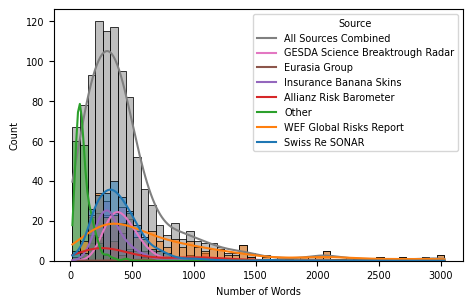

In [59]:
fig, ax = plt.subplots()
g = sns.histplot(
    df_risks.rename(columns={"n_words": "Number of Words"}),
    x="Number of Words",
    common_norm=False,
    kde=True,
    color="gray",
    ax=ax)
g.set_label("All Sources Combined")
g = sns.histplot(
    df_risks.rename(columns={"n_words": "Number of Words"}),
    x="Number of Words",
    hue="Source",
    common_norm=False,
    kde=True,
    ax=ax
)
ax.legend(title="Source", bbox_to_anchor=(1, 1),
         labels=["All Sources Combined", 
                 "GESDA Science Breaktrough Radar",
                 "Eurasia Group",
                 "Insurance Banana Skins",
                 "Allianz Risk Barometer",
                 "Other",
                 "WEF Global Risks Report",
                 "Swiss Re SONAR"
                 ])
plt.savefig(figure_path/"risks_word_counts_hist.pgf", bbox_inches="tight")

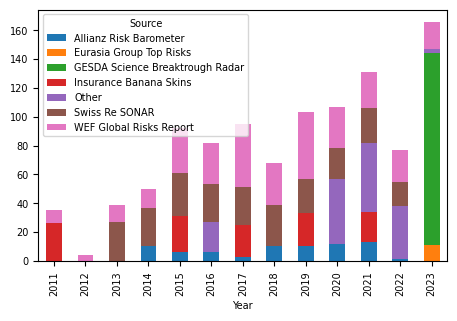

In [60]:
fig, ax = plt.subplots()
df_risks.groupby(["Year", "Source"]).agg({"Title": "count"}).unstack().plot.bar(stacked=True, ax = ax)
ax.legend(title="Source", 
          labels=["WEF Global Risks Report",
                  "Swiss Re SONAR",
                  "Other",
                  "Insurance Banana Skins",
                  "GESDA Science Breaktrough Radar",
                  "Eurasia Group Top Risks",
                  "Allianz Risk Barometer"][::-1])
plt.savefig(figure_path/"risks_reports_per_year_source.pgf", bbox_inches="tight")
plt.savefig(figure_path/"risks_reports_per_year_source.png", bbox_inches="tight")